## Distorsion de l'image

Enfin, nous prenons en compte la distorsion de la lentille. La distorsion est généralement radiale, ce qui signifie que la distorsion des pixels dépend
sur sa distance à l'origine *O*. La distorsion radiale peut être soit positive (distorsion en barillet), soit négative (distorsion en coussinet).
Distorsion). Dans les deux cas, nous pouvons décrire la distorsion avec un modèle quadratique qui mappe le (u,v) idéal et non déformé
coordonnées antérieures aux coordonnées réelles observées avec distorsion (ud, vd).


Puisque la distorsion dépend de l’origine, on obtient l’équation suivante :


![Distortion equation, p. 62](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_3/distortion.png)


L'ampleur de la distorsion dépend du FoV de la caméra et d'un désalignement potentiel entre l'objectif et le capteur optique.

In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
square_size = 2.0
img_mask = "../Chapitre 1/images/*.png"
pattern_size = (7, 9)

figsize = (20, 20)

img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]



keep_idxs=np.ones(num_images)
for i, fn in enumerate(img_names):
    


    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)

    
    found, corners = cv2.findChessboardCorners(img, pattern_size)  
    if not found:
        keep_idxs[i]=0
        print("chessboard not found")
        continue

    
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)


img_names=[img_names[i] for i in range(num_images) if keep_idxs[i]==1]


# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

chessboard not found

RMS: 2.479629261086798
camera matrix:
 [[3.04024857e+03 0.00000000e+00 1.48105062e+03]
 [0.00000000e+00 3.03447385e+03 2.01426083e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 2.05853433e-01 -1.03426280e+00  7.20852043e-04 -4.77205455e-03
  1.33239975e+00]


In [3]:
i=0
# Paramètres intrinsèques des caméras
K=camera_matrix
# Matrice de rotation en radian
R=cv2.Rodrigues(_rvecs[i])[0]
# Vecteur de translation en mètres
t=_tvecs[0].reshape(3,-1)

In [4]:
# Matrice de transformation T = [R|t]
T = np.concatenate((R, t), axis=1)


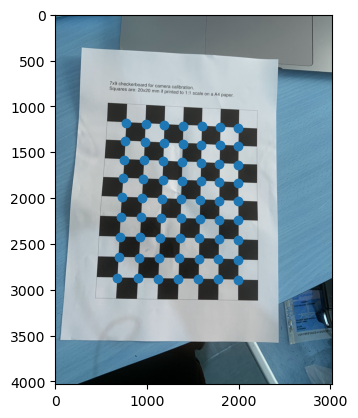

In [5]:
img=cv2.imread(img_names[0])
plt.imshow(img)
plt.scatter(img_points[0][:,0],img_points[0][:,1])


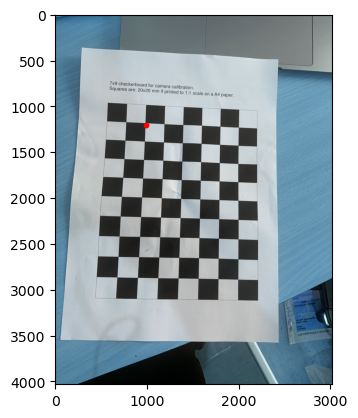

In [6]:
def makeWorldVector(x=0, y=0, z=0):
    """
     Crée un vecteur de coordonnées mondiales à partir des composants x, y, z
     :numéro de paramètre x : coordonnée x du point en mètres
     :numéro de paramètre y : coordonnée y du point en mètres
     :param number z : coordonnée z du point en mètres
     :return : Vecteur en coordonnées mondiales
     :rtype: np.array(x, y, z, 1)
     """
    return np.array(
        [[x],
         [y],
         [z],
         [1]]
    )

def worldToPixels(Pw):
    """
     Convertit un vecteur en coordonnées mondiales en coordonnées de pixels UV
     :param np.array(x, y, z, 1) Pw : vecteur mondial
     :return : (u,v) coordonnées en pixels du point mondial dans le cadre de l'image
     :rtype : Tuple[nombre, nombre]
     """
    Pc = np.matmul(T, Pw)
    Pc_norml = (Pc / Pc[2][0])
    p = np.matmul(K, Pc_norml)
    uv = p[:-1]
    return uv[0], uv[1]

def plotPoints(us, vs):
    """
     Trace une liste de coordonnées de pixels sur une image
     :param List[number] us : Liste des coordonnées u pour les points du nuage de points
     :param List[number] vs : liste des coordonnées V pour les points du nuage de points
     :retour : Aucun
     """
    plt.imshow(img, cmap='gray')
    plt.scatter(x=us, y=vs, c='r', s=10)
    plt.show()

Pw = makeWorldVector(x=2, y=0)
u, v = worldToPixels(Pw)
plotPoints([u], [v])


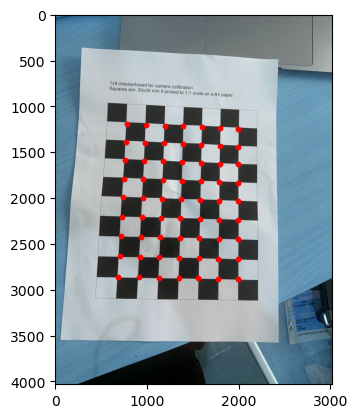

In [7]:
# Charger une image déformée
img = cv2.imread(img_names[0])
us, vs = [], []

# Parcourez tous les points de l'échiquier et dessinez un point sur l'image
for x in range(7):
    for y in range(9):
            # Créez un nouveau vecteur de coordonnées mondiales au coin de l'échiquier
            Pw = makeWorldVector(
                x=square_size*x, 
                y=square_size*y, 
                z=0
            )
            # Convertissez-le en coordonnées de pixels UV et ajoutez-les au tableau us, vs
            u, v = worldToPixels(Pw)
            us.append(u)
            vs.append(v)

# Tracer les résultats
plotPoints([us], [vs])

Nous pouvons rapidement voir que nous avons affaire à une sorte de distorsion radiale et que notre cube ne tomberait PAS correctement sur cette nouvelle image, puisque nous n'avons pas pris en compte la distorsion lors de la conversion des coordonnées du monde en valeurs uv.


Sous Opencv la la distorsion radiale est représentée comme suit :
$$x_{distorted}=x(1+k_1r^2+k_2r^4+k_3r^6)$$
$$y_{distorted}=y(1+k_1r^2+k_2r^4+k_3r^6)$$
De même, une distorsion tangentielle se produit parce que l’objectif de prise d’image n’est pas parfaitement aligné parallèlement au plan d’imagerie. Ainsi, certaines zones de l’image peuvent paraître plus proches que prévu. L’ampleur de la distorsion tangentielle peut être représentée comme ci-dessous :
$$x_{distorted}=x+[2p_1xy+p_2(r^2+2x^2)]$$
$$y_{distorted}=y+[2p_2xy+p_1(r^2+2y^2)]$$
En bref, nous devons trouver cinq paramètres, appelés coefficients de distorsion donnés par :
$$coefficients=(k_1, k_2 ,p_1, p_2 ,k_2)$$

On retrouve quelques points spécifiques dont on connaît déjà les positions relatives (par exemple les coins carrés de l'échiquier). Nous connaissons les coordonnées de ces points dans l'espace réel et nous connaissons les coordonnées dans l'image, nous pouvons donc résoudre les coefficients de distorsion. Pour de meilleurs résultats, nous avons besoin d’au moins 10 modèles de test.

In [8]:
def undistortPoint(point, D):
    """
     Déplace un point dans les coordonnées de caméra normalisées vers une nouvelle position en fonction du facteur de distorsion D.
     :param Tuple[x,y,1] point : point non déformé avec des coordonnées x,y,1 dans le cadre de la caméra
     :param Tuple[dx, dy] D : facteur de distorsion dans les directions x et y
     :retour : point déformé
     :rtype : Tuple[x,y,1]
     """
    k1,k2,p1,p2,k3 = dist_coefs.reshape(-1)
    
    # r^2 = (x^2 + y^2)
    r_squared = point[0] ** 2 + point[1] ** 2
    
    # Calculer la non-distorsion
    point_undistorted = point * (1 + k1*r_squared +k2*r_squared**2+k3*r_squared**3)
    
    r_squared = point_undistorted[0] ** 2 + point_undistorted[1] ** 2
    
    point_undistorted[0]+=(2*p1*point_undistorted[0]*point_undistorted[1])+p2*(r_squared+2*point_undistorted[0]**2)
    point_undistorted[1]+=(2*p2*point_undistorted[0]*point_undistorted[1])+p1*(r_squared+2*point_undistorted[1]**2)
    
    # Assurez-vous que le dernier facteur est toujours 1
    point_undistorted[2] = 1
    
    # Renvoie une valeur déformée
    return point_undistorted

La non-distorsion prend les coordonnées du cadre de la caméra comme entrées. Nous devons donc modifier notre fonction worldToPixels pour prendre en compte la distorsion avant de calculer les valeurs de pixels discrètes.

In [9]:
def worldToPixelsDistorted(Pw, D):
    """
     Convertit un vecteur en coordonnées mondiales en coordonnées de pixels UV en tenant compte de la distorsion
     :param np.array(x, y, z, 1) Pw : vecteur mondial
     :param Tuple[dx, dy] D : facteur de distorsion dans les directions x et y
     :return : (u,v) coordonnées en pixels du point mondial dans le cadre de l'image déformée
     :rtype : Tuple[u, v]
     """
    # Projeter (Xw, Yw, Zw, 0) dans le système de coordonnées des caméras
    Pc_distorted = np.matmul(T, Pw)
    
    # Normaliser par z pour obtenir (Xc, Yc, 1)
    Pc_norml = (Pc_distorted / Pc_distorted[2][0])
    
    # Utiliser un point normalisé pour déformer les coordonnées
    Pc = undistortPoint(Pc_norml, D)
    
    # Projeter x, y, z sur des valeurs de pixels discrètes
    p = np.matmul(K, Pc)
    
    # utilise les deux premières valeurs puisque la dernière est toujours 1 : (u, v, 1). Renvoie-toi, v
    uv = p[:-1]
    return uv[0], uv[1]

Utilisez maintenant notre fonction de non-distorsion pour normaliser notre grille d'échecs

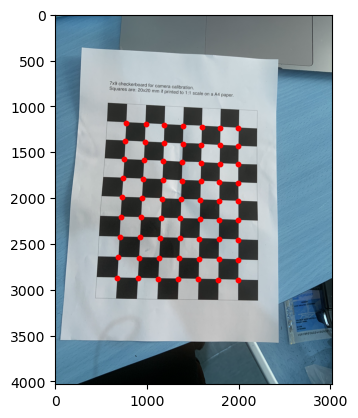

In [10]:



us, vs = [], []

# Create a board of size 9x6
for x in range(7):
    for y in range(9):
            # Create a new world point, each at the base plane with 4m delta in x and y direction
            Pw = makeWorldVector(x=2*x, y=2*y, z=0)
            # Convert world point to pixel coordinates with taking camera distortion into account
            u, v = worldToPixelsDistorted(Pw, dist_coefs)
            # Append found coordinates to list so we can plot them later
            us.append(u)
            vs.append(v)

plotPoints([us], [vs])

Nous constatons que notre distorsion a fonctionné : 
* nous avons réussi à déformer nos estimations ponctuelles pour les adapter à l'image réelle. Mais essayons aussi l'inverse : corrigez la distorsion d'une image de manière à conserver les lignes droites. 

Pour ce faire, nous pourrions en théorie inverser notre fonction de cartographie et mapper chaque pixel de l'image déformée à l'image d'origine.

Puisque cela nécessiterait d'inverser notre fonction de mappage, ce qui entraînerait un problème polynomial coûteux, nous procédons plus simplement : nous parcourons les pixels d'une image vierge et trouvons - pour chaque pixel - celui correspondant dans le pixel déformé.

In [11]:
def undistortImage(img, K, D):
    """
     Déforme une image en fonction de la distorsion D et des valeurs intrinsèques K
     :param np.ndarray[number, number] img : image d'entrée, niveaux de gris
     :param np.ndarray[float, float] K : intrinsèques de la caméra
     :param Tuple[dx, dy] D : facteur de distorsion dans les directions x et y
     :return: Distorsion corrigée de l'image img
     :rtype: np.ndarray[numéro, numéro]
     """
    undistorted_image = np.zeros(img.shape)
    height, width = undistorted_image.shape[0], undistorted_image.shape[1]

    # Bouclez sur chaque pixel de notre image non déformée
    for y in range(height):
        for x in range(width):
            
            # Convertir le pixel en coordonnées normalisées
            normalized_coords = np.linalg.lstsq(K, np.array([x, y, 1]))[0]
            
            # Trouver les coordonnées de la contrepartie dans une image déformée
            distorted_coords = undistortPoint(normalized_coords, D)
            
            # Convertir les coordonnées homologues en valeurs de pixels
            pixel_cords = np.matmul(K, distorted_coords)
            
            # Normaliser les valeurs des pixels
            u = int(pixel_cords[0] / pixel_cords[2])
            v = int(pixel_cords[1] / pixel_cords[2])

            # La vérification de la valeur du pixel existe dans l'image déformée, si c'est le cas, écrivez-la sur l'image non déformée
             # à la position d'origine. Sinon, laissez-le noir tel quel
            if (0 <= u < width) and (0 <= v < height):
                undistorted_image[y][x] = img[v][u]
    return undistorted_image

Nous pouvons désormais déformer notre image avant de convertir les coordonnées mondiales en coordonnées de pixels discrétisées, ce qui conduit à une image parfaitement visible sans aucune distorsion, ce qui implique que nous n'avons plus besoin de déformer nos points avant de les dessiner sur l'image.

La fonction ci-dessus prendra un certain temps puisqu'un système linéaire d'équations doit être résolu pour chacun de nos pixels.

In [12]:
img = undistortImage(img, K, dist_coefs).astype('uint8')

C:\Users\nmadali\AppData\Local\Temp\ipykernel_14796\2402927009.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  normalized_coords = np.linalg.lstsq(K, np.array([x, y, 1]))[0]


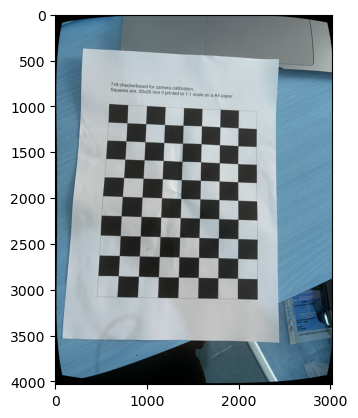

In [13]:
plt.imshow(img)

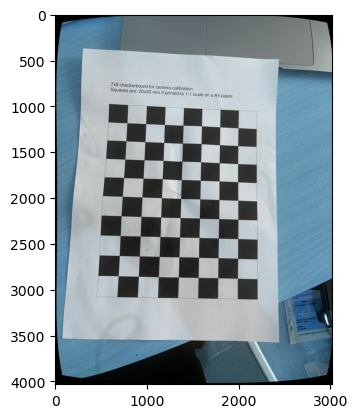

In [14]:
# undistort
plt.imshow( cv2.undistort(cv2.imread(img_names[0]), K, dist_coefs) )

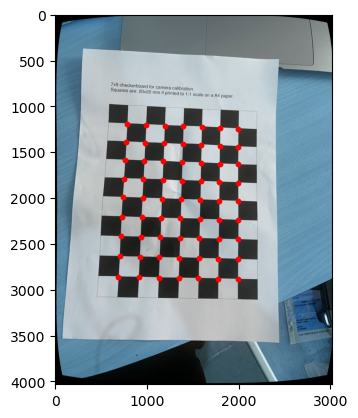

In [15]:



us, vs = [], []

# Create a board of size 9x6
for x in range(7):
    for y in range(9):
        # Create a new world point, each at the base plane with 4m delta in x and y direction
            Pw = makeWorldVector(x=2*x, y=2*y, z=0)
            # Convert world point to pixel coordinates - there is NO NEED to consider distortion now
            u, v = worldToPixels(Pw)
            # Append found coordinates to list so we can plot them later
            us.append(u)
            vs.append(v)

plotPoints([us], [vs])